These three methods—**Finite Differences (FD), Pathwise Sensitivity (PS), and Likelihood Ratio Method (LRM)**—are widely used in **computational finance** for estimating derivatives (sensitivities) of option prices or risk measures. Here's how they compare:

### **1. Finite Differences (FD)**
- **Concept:** Approximate the derivative by perturbing the input (e.g., price, volatility) and computing the change in output.
- **Mathematical Formulation:**  
  $$
  \frac{\partial V}{\partial x} \approx \frac{V(x + \epsilon) - V(x)}{\epsilon}
  $$
  for small **ε**.
- **Pros:**
  - Simple to implement.
  - Works with **any** pricing model (closed-form, Monte Carlo, PDE-based).
- **Cons:**
  - Computationally expensive (**needs multiple simulations**).
  - Can be noisy (accuracy depends on ε).
  - Bias issues for **large ε**, numerical instability for **small ε**.

### **2. Pathwise Sensitivity (PS)**
- **Concept:** Uses differentiation inside the Monte Carlo simulation—if the derivative of the payoff exists, it can be computed directly.
- **Mathematical Formulation:**  
  $$
  \frac{\partial V}{\partial x} = \mathbb{E} \left[ \frac{\partial f(X)}{\partial x} \right]
  $$
- **Pros:**
  - **More efficient** than FD (requires only **one** simulation).
  - **Less noisy** (direct estimation of derivative).
- **Cons:**
  - Requires smooth payoff functions—**not applicable to discontinuous payoffs** (e.g., digital options).
  - Can have variance issues.

### **3. Likelihood Ratio Method (LRM)**
- **Concept:** Instead of differentiating the payoff, it differentiates the probability density function (PDF).
- **Mathematical Formulation:**  
  $$
  \frac{\partial V}{\partial x} = \mathbb{E} \left[ f(X) \frac{\partial \log p(X)}{\partial x} \right]
  $$
- **Pros:**
  - Works for **any payoff function** (even discontinuous ones!).
  - Less biased compared to FD.
- **Cons:**
  - Higher variance (can produce noisy estimates).
  - Requires knowledge of the **PDF derivative**, which might be complex.

### **Summary Comparison Table**
| Method | Efficiency | Applicability | Accuracy | Robustness |
|--------|------------|-------------|---------|----------|
| **FD** | Slow (needs multiple sims) | Works for any model | Bias/noise issues | Unstable for very small ε |
| **PS** | Fast (single simulation) | Requires smooth payoff | High accuracy | Struggles with discontinuous payoffs |
| **LRM** | Medium (one sim, but noisy) | Works for all payoffs | High variance | Needs PDF derivative |

### **Which one should you use?**
- If you want a quick, straightforward approach → **Finite Differences**.
- If you have a smooth payoff function → **Pathwise Sensitivity**.
- If your payoff function has jumps/discontinuities → **Likelihood Ratio Method**.

Each method has its niche, and sometimes **hybrid approaches** (combining FD with variance reduction techniques) work best.

Running simulation with 5 paths
Running simulation with 1046 paths
Running simulation with 2087 paths
Running simulation with 3129 paths
Running simulation with 4170 paths
Running simulation with 5212 paths
Running simulation with 6253 paths
Running simulation with 7295 paths
Running simulation with 8336 paths
Running simulation with 9378 paths
Running simulation with 10419 paths
Running simulation with 11461 paths
Running simulation with 12502 paths
Running simulation with 13543 paths
Running simulation with 14585 paths
Running simulation with 15626 paths
Running simulation with 16668 paths
Running simulation with 17709 paths
Running simulation with 18751 paths
Running simulation with 19792 paths
Running simulation with 20834 paths
Running simulation with 21875 paths
Running simulation with 22917 paths
Running simulation with 23958 paths
Running simulation with 25000 paths


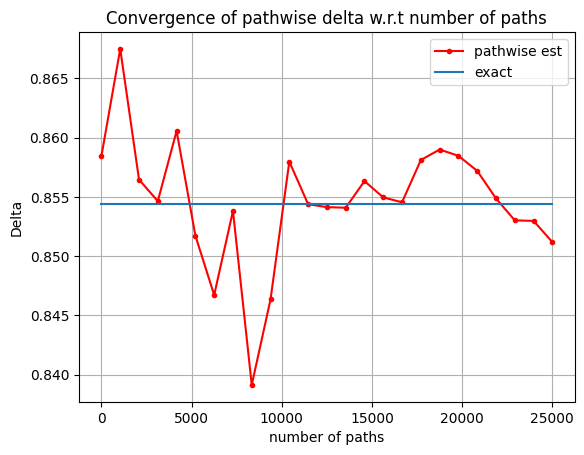

In [1]:
#%%
"""
Created on Mar 09 2019
The Heston model and computation of Delta, dV/dS0, with the pathwise sensitivity
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import enum 

# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):


    # cf   - Characteristic function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))

    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method

    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))

    # Characteristic function for the Heston model    

    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

def CIR_Sample(NoOfPaths,kappa,gamma,vbar,s,t,v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    sample = c* np.random.noncentral_chisquare(delta,kappaBar,NoOfPaths)
    return  sample

def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):    
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1

        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        
        # Exact samples for the variance process

        V[:,i+1] = CIR_Sample(NoOfPaths,kappa,gamma,vbar,0,dt,V[:,i])
        k0 = (r -rho/gamma*kappa*vbar)*dt
        k1 = (rho*kappa/gamma -0.5)*dt - rho/gamma
        k2 = rho / gamma
        X[:,i+1] = X[:,i] + k0 + k1*V[:,i] + k2 *V[:,i+1] + np.sqrt((1.0-rho**2)*V[:,i])*(W1[:,i+1]-W1[:,i])
        time[i+1] = time[i] +dt
        
    # Compute exponent

    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

def PathwiseDelta(S0,S,K,r,T):
    temp1 = S[:,-1]>K
    return np.exp(-r*T)*np.mean(S[:,-1]/S0*temp1)

def mainCalculation():

    # Monte Carlo setting

    NoOfPathsMax = 25000
    NoOfSteps    = 1000
    
    # Heston model parameters

    gamma = 0.5
    kappa = 0.5
    vbar  = 0.04
    rho   = -0.9
    v0    = 0.04
    T     = 1.0
    S0   = 100.0
    r     = 0.1
    CP    = OptionType.CALL
    
    # We define a range of strikes and check the convergence

    K = [S0]
    
    # Reference solution with the COS method

    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    
    # The COS method

    dS0 = 1e-5
    V_S_plus_delta = CallPutOptionPriceCOSMthd(cf, CP, S0+dS0, r, T, K, 1000, 8)
    V_S_minus_delta = CallPutOptionPriceCOSMthd(cf, CP, S0-dS0, r, T, K, 1000, 8)
    
    # Delta is estimated by the COS method with the central differences

    hestonDeltaExact = (V_S_plus_delta-V_S_minus_delta)/(2.0*dS0)
    
    NoOfPathsV = np.linspace(5,NoOfPathsMax,25)
    deltaPathWiseV = np.zeros([len(NoOfPathsV),1])

    for (idx,nPaths) in enumerate(NoOfPathsV):
        print('Running simulation with {0} paths'.format(int(nPaths)))
        
        # Almost exact simulation

        np.random.seed(1)
        paths = GeneratePathsHestonAES(int(nPaths),NoOfSteps,T,r,S0,kappa,gamma,rho,vbar,v0)
        S= paths["S"]
         
        # Delta -- pathwise

        delta_pathwise = PathwiseDelta(S0,S,K,r,T)
        deltaPathWiseV[idx]= delta_pathwise
    
    plt.figure(1)
    plt.grid()
    plt.plot(NoOfPathsV,deltaPathWiseV,'.-r')
    plt.plot(NoOfPathsV,hestonDeltaExact*np.ones([len(NoOfPathsV),1]))
    plt.xlabel('number of paths')
    plt.ylabel('Delta')
    plt.title('Convergence of pathwise delta w.r.t number of paths')
    plt.legend(['pathwise est','exact'])
        
mainCalculation()